In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import numpy as np

In [3]:
img_path = '/media/nas/datasets/MIRAGE_2020/FSCIL_approaches/hf-project/results/images/'

metric_dict = {
    'F1 Score All': 'all_metrics_f1_scoreall-material.parquet',
    'F1 Score Forgetting All': 'all_metrics_forgetting_f1_scoreall-material.parquet',
    'F1 Score Intransigence': 'new_metrics_f1_scoreintransigence-material.parquet',
    'F1 Score Drop All': 'all_metrics_f1_scoredrop all-material.parquet',
    'F1 Score Drop Old': 'old_metrics_f1_scoredrop old-material.parquet'
}

lower_is_better_dict = {
    'F1 Score All': False,
    'F1 Score Forgetting All': True,
    'F1 Score Intransigence': True,
    'F1 Score Drop All': True,
    'F1 Score Drop Old': True
}

scenario_discrs_dict = {
    'CV': ['can5ba20inr5stp5', 'can5ba20in10stp3', 'can5ba20in20stp2'],
    'TC': ['can5ba34inr1stp7', 'can5ba34inr2stp4', 'can5ba34inr3stp3']
}

scenario_descr_dict = {
    'CV': 'Computer Vision (CV) - Base: 20; Incr: 5, 10, and 20 [Rank @ 40 Classes]',
    'TC': 'Traffic Classification (TC) - Base: 34; Incr: 1, 2, and 3 [Rank @ 40 Classes]'
}

In [49]:
import os
import portalocker as pl
import json

def get_ts(df_filename):
    return '-'.join(df_filename.split('/')[-1].split('-')[1:]).split('_')[0]


def get_args_dict(df_filename):
    ts = get_ts(df_filename)
    try:
        with open('/'.join(df_filename.split('/')[:-2] + ['args-%s.txt' % ts])) as fin:
            return json.loads(fin.read())
    except FileNotFoundError as _:
        with open('/'.join(df_filename.split('/')[:-1] + ['args-%s.txt' % ts])) as fin:
            return json.loads(fin.read())

def preprocess_metrics(metric, metr_dict, mety_dict, df_filenames, plot_path, analysis, override=True, appr_dict=None,
                       nc_incr_tasks=None):
    metric, metric_type = metric
    print('Preprocessing %s %s %s' % (analysis, metric, metric_type))
    
#     if metric_type != 'intransigence':
#         return pd.DataFrame()

    material_path = os.path.join(plot_path, 'material')
    with pl.Lock('lock'):
        if not os.path.exists(material_path):
            os.makedirs(material_path)
            
    if nc_incr_tasks is None:
        nc_incr_tasks = [0] * len(df_filenames)

    discr = mety_dict[metric_type]
    normal_discr = mety_dict['normal'][analysis]
    try:
        discr = discr[analysis]
    except:
        pass

    average_analysis = analysis in ['all', 'new', 'old']
    normal_metric_col = ' '.join([metr_dict[metric], normal_discr]).strip()

    preprocessed_fn = os.path.join(material_path,
                                   '%s_metrics_%s%s-material.parquet' % (analysis, metric, discr.lower()))
    if os.path.exists(preprocessed_fn) and override is None:
        override = input('File "%s" exists: override [Y, n]? ' % preprocessed_fn).lower() != 'n'
    if not os.path.exists(preprocessed_fn) or override:  # Generate or Override
        common_columns = ['Seed', 'Network', 'Approach', 'Episode', 'Batch Size', 'Patience', 'Increment']
        if average_analysis:
            df = pd.DataFrame(columns=common_columns + [normal_metric_col])
        else:  # if analysis == 'per_episode':
            df = pd.DataFrame(columns=common_columns + ['Task', normal_metric_col])
        for df_filename, nc_incr_task in tqdm(list(zip(df_filenames, nc_incr_tasks))):
            args_dict = get_args_dict(df_filename)
            assert args_dict.get('nc_incr_tasks', nc_incr_task) > 0, 'Please set --nc-incr-tasks argument.'
            row = {'Seed': args_dict['seed'], 'Network': args_dict['network'],
                   'Approach': '%s' % appr_dict[args_dict['approach']], 'Batch Size': args_dict['batch_size'],
                   'Patience': args_dict['lr_patience'],
                   'Out Features Size': args_dict.get('out_features_size', 200),
                   'Momentum': args_dict.get('momentum', .0)}
            tmp_df = pd.read_parquet(df_filename)
            tmp_df[metric] = tmp_df[metric].apply(lambda x: [np.nan if v is None else v for v in x])
            if 'nc_first_task' in tmp_df:
                tmp_df_g = tmp_df.groupby(['nc_first_task', 'nc_incr_tasks'])
            else:
                tmp_df_g = [((args_dict['nc_first_task'], args_dict['nc_incr_tasks']), tmp_df)]
            for g, tmp_d in tmp_df_g:
                values = [[v0 * 100 for v0 in v] for v in tmp_d[metric].values]
                _nc_first_task = g[0]
                _nc_incr_tasks = g[1]
                for ep, value in enumerate(values):
                    row.update({'Episode': ep,
                                'Increment': _nc_incr_tasks,
                                '#Classes': _nc_first_task + _nc_incr_tasks * ep})
                    if average_analysis:
                        if 'all' in analysis:
                            row.update({normal_metric_col: value[0], 'Type': 'All'})
                            df = df.append(row, ignore_index=True)
                        else:
                            for val, type in zip(value, ['Old', 'New']):
                                row.update({normal_metric_col: val, 'Type': type})
                                df = df.append(row, ignore_index=True)
                    else:  # if analysis == 'per_episode':
                        for task, val in enumerate(value):
                            row.update({'Task': task, normal_metric_col: val})
                            df = df.append(row, ignore_index=True)
        assert len(df) > 0
        if metric_type in ['expectation', 'intransigence']:
            df_UB = df[df['Approach'] == 'Scratch'].reset_index(drop=True)
            df = df[df['Approach'] != 'Scratch'].reset_index(drop=True)
            metric_col = ' '.join([metr_dict[metric], discr]).strip()
            columns = [col for col in list(df.columns) if
                       col not in [normal_metric_col, 'Approach', 'Momentum',
#                                    'Episode', 'Increment', 'Task'
                                  ]]
            episode_index = columns.index('Episode')
            try:
                task_index = columns.index('Task')
            except ValueError as _:
                pass
            df[metric_col] = np.nan
            df_g = df.groupby(columns)
            groups = list(df_g.groups)
            del df_g
            for group in groups:
#                 if metric_type == 'intransigence' and not average_analysis:
#                     if group[episode_index] != group[task_index]:
#                         continue
                df_filter = functools.reduce(lambda x, y: x & y, [df[col] == g for col, g in zip(columns, group)])
                df_UB_filter = functools.reduce(lambda x, y: x & y, [df_UB[col] == g for col, g in zip(columns, group)])
                if not len(df_UB.loc[df_UB_filter]):
                    print('WARNING: group (%s) does not present Upperbound model.' % ', '.join([str(v) for v in group]))
                    continue
                else:
                    ub_value = df_UB.loc[df_UB_filter, normal_metric_col].values[0]
                    df.loc[df_filter, metric_col] = df.loc[df_filter, normal_metric_col].apply(
                        (lambda x: x / ub_value * 100) if metric_type == 'expectation' else (lambda x: ub_value - x)
                    )
        df.to_parquet(preprocessed_fn)
    else:
        print('WARNING: using already computed material.')
        df = pd.read_parquet(preprocessed_fn)

    if '#Classes' in df:
        min_classes = df[df['Approach'] != appr_dict['scratch']]['#Classes'].min()
        df = df[df['#Classes'] >= min_classes]

    print(df)
    return df

In [ ]:
res_path = '/media/nas/datasets/MIRAGE_2020/FSCIL_approaches/hf-project/results'
analysis = 'per_episode_metrics'

ms = ['accuracy_score', 'forgetting_accuracy_score', 'accuracy_score', 'forgetting_f1_score']
m_dict = {'accuracy_score':'Accuracy', 'forgetting_accuracy_score':'Accuracy Forgetting',
          'forgetting_f1_score':'F1 Score Forgetting'}
ts = ['normal', 'normal', 'intransigence', 'normal']
t_dict = {'normal':{analysis:'Per Episode'}, 'intransigence':{analysis:'Per Episode Intransigence'}}
appr_dict = {'icarl': 'iCaRL-FACIL', 'icarlo': 'iCaRL-original', 'icarlp': 'iCaRL+', 'bic': 'BiC', 'il2m': 'IL2M',
                 'lwf': 'LwF', 'finetuning': 'FineTuning', 'lucir': 'LUCIR', 'ewc': 'EWC', 'joint': 'Joint',
                 'scratch': 'Scratch', 'freezing': 'Fixed-Repr', 'eeil': 'EEIL', 'ssil': 'SS-IL'}

per_episode_dfs = dict()

for scenario_discrs in scenario_discrs_dict:
    per_episode_dfs[scenario_discrs] = dict()
    for img_d in scenario_discrs_dict[scenario_discrs]:
        per_episode_dfs[scenario_discrs][img_d] = dict()
        exp_name = '*'.join([img_d[i:i+2] for i in range(0,len(img_d),2)])
        filenames = glob('%s/*%s/**/*%s.parquet' % (res_path, exp_name, analysis), recursive=True)
        filenames.extend(glob('%s_UB/*%s/**/*%s.parquet' % (res_path, 'scratch', analysis), recursive=True))
        plot_path = glob('%s/%s_*/' % (img_path, img_d))[0]
        for m, t in zip(ms[-1:], ts[-1:]):
            df = preprocess_metrics((m, t), m_dict, t_dict, filenames,
                                    plot_path, analysis, False, appr_dict)
            per_episode_dfs[scenario_discrs][img_d]['%s_%s' % (m, t)] = df


Preprocessing per_episode_metrics forgetting_f1_score normal


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [01:01<00:00,  1.11it/s]


     Seed     Network Approach Episode Batch Size Patience Increment Task  \
0       1  Lopez17CNN     IL2M       0         64       20         5    0   
1       1  Lopez17CNN     IL2M       1         64       20         5    0   
2       1  Lopez17CNN     IL2M       1         64       20         5    1   
3       1  Lopez17CNN     IL2M       2         64       20         5    0   
4       1  Lopez17CNN     IL2M       2         64       20         5    1   
...   ...         ...      ...     ...        ...      ...       ...  ...   
1598   10  Lopez17CNN  Scratch       1         64       20         3    0   
1599   10  Lopez17CNN  Scratch       1         64       20         3    1   
1600   10  Lopez17CNN  Scratch       2         64       20         3    0   
1601   10  Lopez17CNN  Scratch       2         64       20         3    1   
1602   10  Lopez17CNN  Scratch       2         64       20         3    2   

      F1 Score Forgetting Per Episode  #Classes  Momentum  Out Features Siz

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:41<00:00,  1.56it/s]


     Seed     Network    Approach Episode Batch Size Patience Increment Task  \
0       2  Lopez17CNN  FineTuning       0         64       20        10    0   
1       2  Lopez17CNN  FineTuning       1         64       20        10    0   
2       2  Lopez17CNN  FineTuning       1         64       20        10    1   
3       2  Lopez17CNN  FineTuning       2         64       20        10    0   
4       2  Lopez17CNN  FineTuning       2         64       20        10    1   
...   ...         ...         ...     ...        ...      ...       ...  ...   
1061   10  Lopez17CNN     Scratch       1         64       20         3    0   
1062   10  Lopez17CNN     Scratch       1         64       20         3    1   
1063   10  Lopez17CNN     Scratch       2         64       20         3    0   
1064   10  Lopez17CNN     Scratch       2         64       20         3    1   
1065   10  Lopez17CNN     Scratch       2         64       20         3    2   

      F1 Score Forgetting Per Episode  

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:36<00:00,  1.86it/s]


    Seed     Network Approach Episode Batch Size Patience Increment Task  \
0      0  Lopez17CNN      LwF       0         64       20        20    0   
1      0  Lopez17CNN      LwF       1         64       20        20    0   
2      0  Lopez17CNN      LwF       1         64       20        20    1   
3      1  Lopez17CNN      LwF       0         64       20        20    0   
4      1  Lopez17CNN      LwF       1         64       20        20    0   
..   ...         ...      ...     ...        ...      ...       ...  ...   
911   10  Lopez17CNN  Scratch       1         64       20         3    0   
912   10  Lopez17CNN  Scratch       1         64       20         3    1   
913   10  Lopez17CNN  Scratch       2         64       20         3    0   
914   10  Lopez17CNN  Scratch       2         64       20         3    1   
915   10  Lopez17CNN  Scratch       2         64       20         3    2   

     F1 Score Forgetting Per Episode  #Classes  Momentum  Out Features Size  
0        

 81%|████████████████████████████████████████████████████████████████████████████████████████▌                    | 52/64 [00:50<00:11,  1.09it/s]

In [20]:
tmp_df = per_episode_dfs['CV']['can5ba20inr5stp5']['accuracy_score_normal']
tmp_df[(tmp_df['Episode']==2) & (tmp_df['Task']==2) & (tmp_df['Seed']==0) & (tmp_df['Increment']==5)]

,Seed,Network,Approach,Episode,Batch Size,Patience,Increment,Task,Accuracy Per Episode,#Classes,Momentum,Out Features Size
35,0,Lopez17CNN,IL2M,2,64,20,5,2,92.020419,30.0,0.0,200.0
110,0,Lopez17CNN,iCaRL+,2,64,20,5,2,92.127888,30.0,0.0,200.0
155,0,Lopez17CNN,LUCIR,2,64,20,5,2,86.888769,30.0,0.0,200.0
245,0,Lopez17CNN,iCaRL-original,2,64,20,5,2,27.565825,30.0,0.0,200.0
305,0,Lopez17CNN,iCaRL-FACIL,2,64,20,5,2,26.249328,30.0,0.0,200.0
380,0,Lopez17CNN,EEIL,2,64,20,5,2,92.262225,30.0,0.0,200.0
470,0,Lopez17CNN,BiC,2,64,20,5,2,67.221924,30.0,0.0,200.0
530,0,Lopez17CNN,SS-IL,2,64,20,5,2,66.711445,30.0,0.0,200.0
620,0,Lopez17CNN,FineTuning,2,64,20,5,2,84.981193,30.0,0.9,200.0
680,0,Lopez17CNN,Fixed-Repr,2,64,20,5,2,8.301988,30.0,0.0,200.0


In [22]:
tmp_df = per_episode_dfs['CV']['can5ba20inr5stp5']['forgetting_accuracy_score_normal']
tmp_df[(tmp_df['Episode']==2) & (tmp_df['Task']==2) & (tmp_df['Seed']==0) & (tmp_df['Increment']==5)]

,Seed,Network,Approach,Episode,Batch Size,Patience,Increment,Task,Accuracy Forgetting Per Episode,#Classes,Momentum,Out Features Size
35,0,Lopez17CNN,IL2M,2,64,20,5,2,NaN,30.0,0.0,200.0
110,0,Lopez17CNN,iCaRL+,2,64,20,5,2,NaN,30.0,0.0,200.0
155,0,Lopez17CNN,LUCIR,2,64,20,5,2,NaN,30.0,0.0,200.0
245,0,Lopez17CNN,iCaRL-original,2,64,20,5,2,NaN,30.0,0.0,200.0
305,0,Lopez17CNN,iCaRL-FACIL,2,64,20,5,2,NaN,30.0,0.0,200.0
380,0,Lopez17CNN,EEIL,2,64,20,5,2,NaN,30.0,0.0,200.0
470,0,Lopez17CNN,BiC,2,64,20,5,2,NaN,30.0,0.0,200.0
530,0,Lopez17CNN,SS-IL,2,64,20,5,2,NaN,30.0,0.0,200.0
620,0,Lopez17CNN,FineTuning,2,64,20,5,2,NaN,30.0,0.9,200.0
680,0,Lopez17CNN,Fixed-Repr,2,64,20,5,2,NaN,30.0,0.0,200.0


In [21]:
tmp_df = per_episode_dfs['CV']['can5ba20inr5stp5']['accuracy_score_intransigence']
tmp_df[(tmp_df['Episode']==2) & (tmp_df['Task']==2) & (tmp_df['Seed']==0) & (tmp_df['Increment']==5)]

,Seed,Network,Approach,Episode,Batch Size,Patience,Increment,Task,Accuracy Per Episode,#Classes,Momentum,Out Features Size,Accuracy Per Episode Intransigence
35,0,Lopez17CNN,IL2M,2,64,20,5,2,92.020419,30.0,0.0,200.0,-11.687265
110,0,Lopez17CNN,iCaRL+,2,64,20,5,2,92.127888,30.0,0.0,200.0,-11.794734
155,0,Lopez17CNN,LUCIR,2,64,20,5,2,86.888769,30.0,0.0,200.0,-6.555615
245,0,Lopez17CNN,iCaRL-original,2,64,20,5,2,27.565825,30.0,0.0,200.0,52.767329
305,0,Lopez17CNN,iCaRL-FACIL,2,64,20,5,2,26.249328,30.0,0.0,200.0,54.083826
380,0,Lopez17CNN,EEIL,2,64,20,5,2,92.262225,30.0,0.0,200.0,-11.929070
470,0,Lopez17CNN,BiC,2,64,20,5,2,67.221924,30.0,0.0,200.0,13.111231
530,0,Lopez17CNN,SS-IL,2,64,20,5,2,66.711445,30.0,0.0,200.0,13.621709
620,0,Lopez17CNN,FineTuning,2,64,20,5,2,84.981193,30.0,0.9,200.0,-4.648039
680,0,Lopez17CNN,Fixed-Repr,2,64,20,5,2,8.301988,30.0,0.0,200.0,72.031166


In [5]:
df_rank = pd.DataFrame(columns=['Approach', 'Group', 'Metric', 'Rank'])
fixed_xorder = dict()
xorder = dict()
for scenario_discrs in tqdm(scenario_discrs_dict):
    fixed_xorder[scenario_discrs] = None
    xorder[scenario_discrs] = dict()
    for metric in metric_dict:
        xorder[scenario_discrs][metric] = None
        files = []
        for scenario_discr in scenario_discrs_dict[scenario_discrs]:
            files.extend(glob('%s/%s_*/material/%s' % (img_path, scenario_discr, metric_dict[metric])))
        df = pd.DataFrame()
        for file in files:
            df = df.append(pd.read_parquet(file), ignore_index=True)

        df = df[df['Approach'] != 'Scratch']

        df_40 = df[df['#Classes'] == 40]

        for g, d in df_40.groupby(['Seed', 'Increment']):
            tmp_d = d.drop_duplicates('Approach')
            tmp_df_rank = pd.DataFrame()
            row = {'Scenario': scenario_discrs, 'Group': g, 'Metric': metric}
            # if len(d) != 12:
            #     continue
            for r, appr in enumerate(
                    tmp_d.sort_values(metric, ascending=lower_is_better_dict[metric])['Approach'].values):
                row.update({'Approach': appr, 'Rank': r + 1,
                            'Value [%]': tmp_d[tmp_d['Approach'] == appr][metric].values[0]})
                tmp_df_rank = tmp_df_rank.append(row, ignore_index=True)
            prev_val = tmp_df_rank.loc[0, 'Value [%]']
            for i in range(len(tmp_df_rank)):
                curr_val = tmp_df_rank.loc[i, 'Value [%]']
                tmp_df_rank.loc[i, 'Drop from Previous [%]'] = (prev_val - curr_val) * (
                    -1 if lower_is_better_dict[metric] else 1)
                prev_val = curr_val
            df_rank = df_rank.append(tmp_df_rank, ignore_index=True)

        if fixed_xorder[scenario_discrs] is None:
            fixed_xorder[scenario_discrs] = list(
                df_rank[df_rank['Scenario'] == scenario_discrs].groupby('Approach')['Rank'].mean().sort_values().index)
        
        if xorder[scenario_discrs][metric] is None:
            xorder[scenario_discrs][metric] = list(
                df_rank[(df_rank['Scenario'] == scenario_discrs) & (df_rank['Metric'] == metric)].groupby(
                    'Approach')['Rank'].mean().sort_values().index)

100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:25<00:00, 12.84s/it]


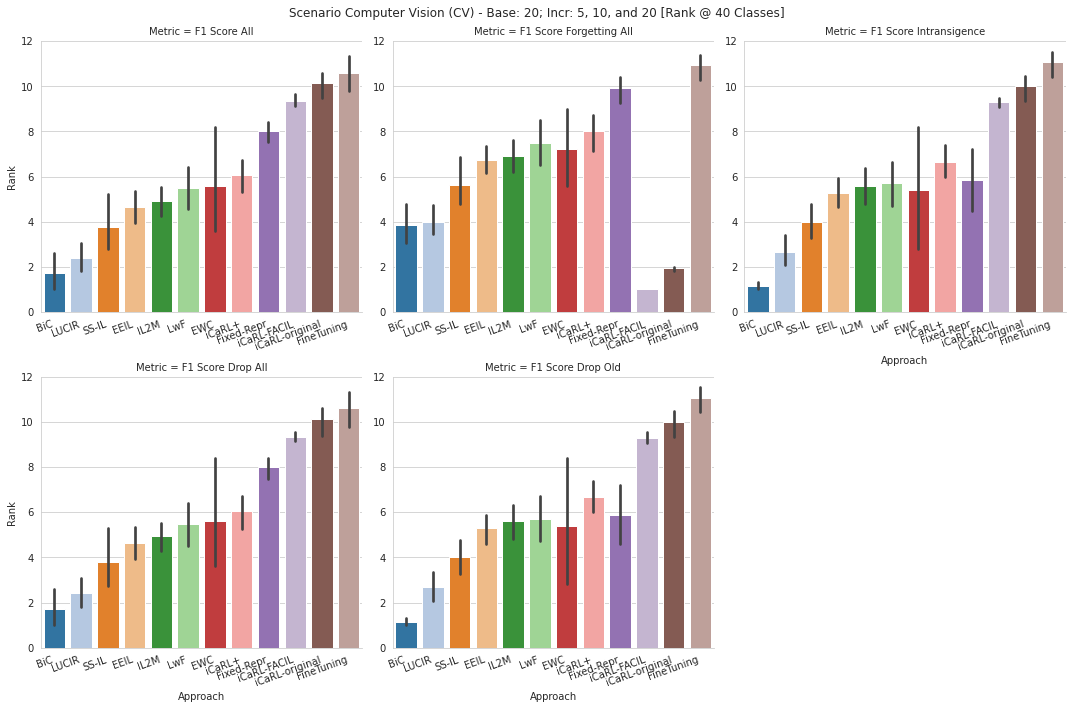

In [6]:
sns.set_style("whitegrid")

for scenario_discrs in scenario_discrs_dict:
    g = sns.catplot(x='Approach', y='Rank', data=df_rank[df_rank['Scenario'] == scenario_discrs], col='Metric',
                    kind='bar', order=fixed_xorder[scenario_discrs], col_wrap=3, sharex=False, sharey=False,
                    palette='tab20')
    g.set(ylim=(0, 12))
    g.set_xticklabels(rotation=20, ha='right')
    g.fig.suptitle('Scenario %s' % scenario_descr_dict[scenario_discrs])

    plt.tight_layout()
    plt.show()
    break

In [7]:
print(df_rank.columns)
df_rank['Group'].unique()

Index(['Approach', 'Group', 'Metric', 'Rank', 'Scenario', 'Value [%]',
       'Drop from Previous [%]'],
      dtype='object')


array([(0, 5), (0, 10), (0, 20), (1, 5), (1, 10), (1, 20), (2, 5),
       (2, 10), (2, 20), (3, 5), (3, 10), (3, 20), (4, 5), (4, 10),
       (4, 20), (0, 1), (0, 2), (0, 3), (1, 1), (1, 2), (1, 3), (2, 1),
       (2, 2), (2, 3), (3, 1), (3, 2), (3, 3), (4, 1), (4, 2), (4, 3)],
      dtype=object)

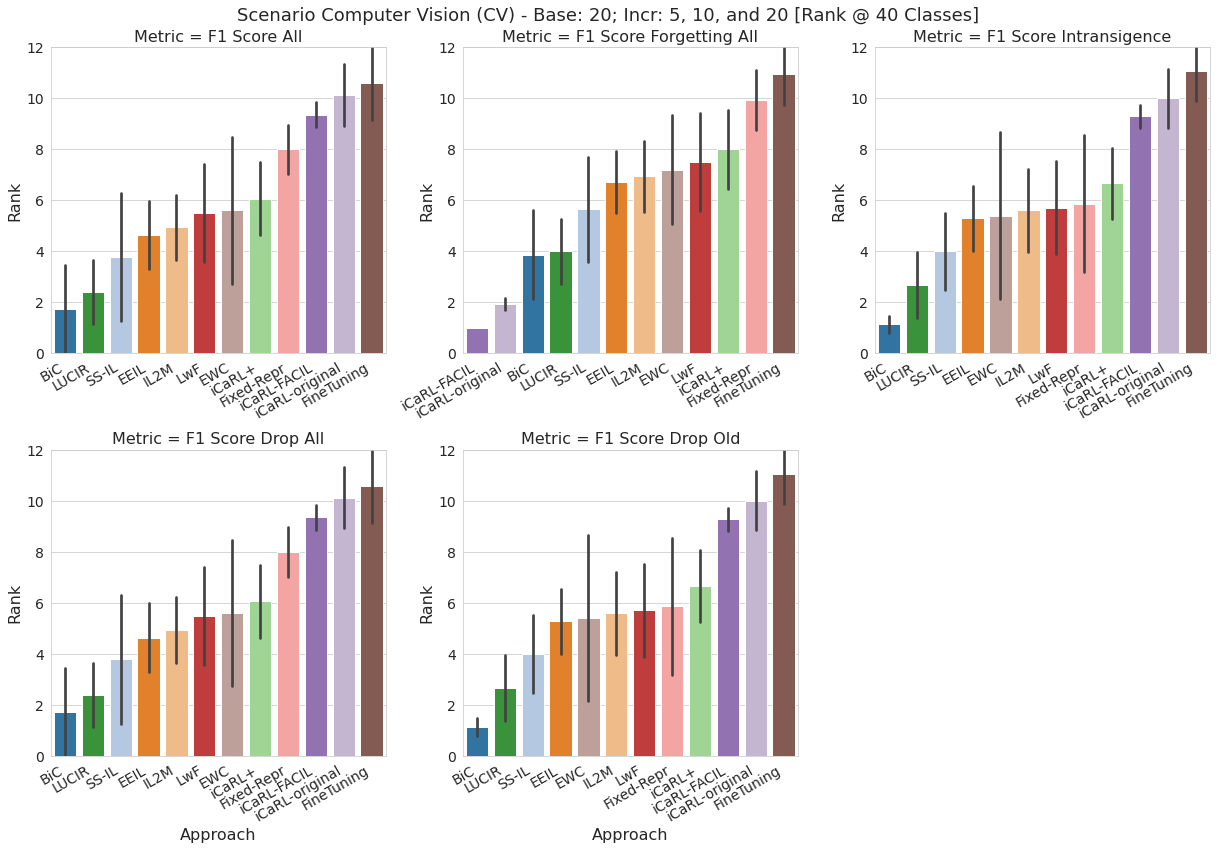

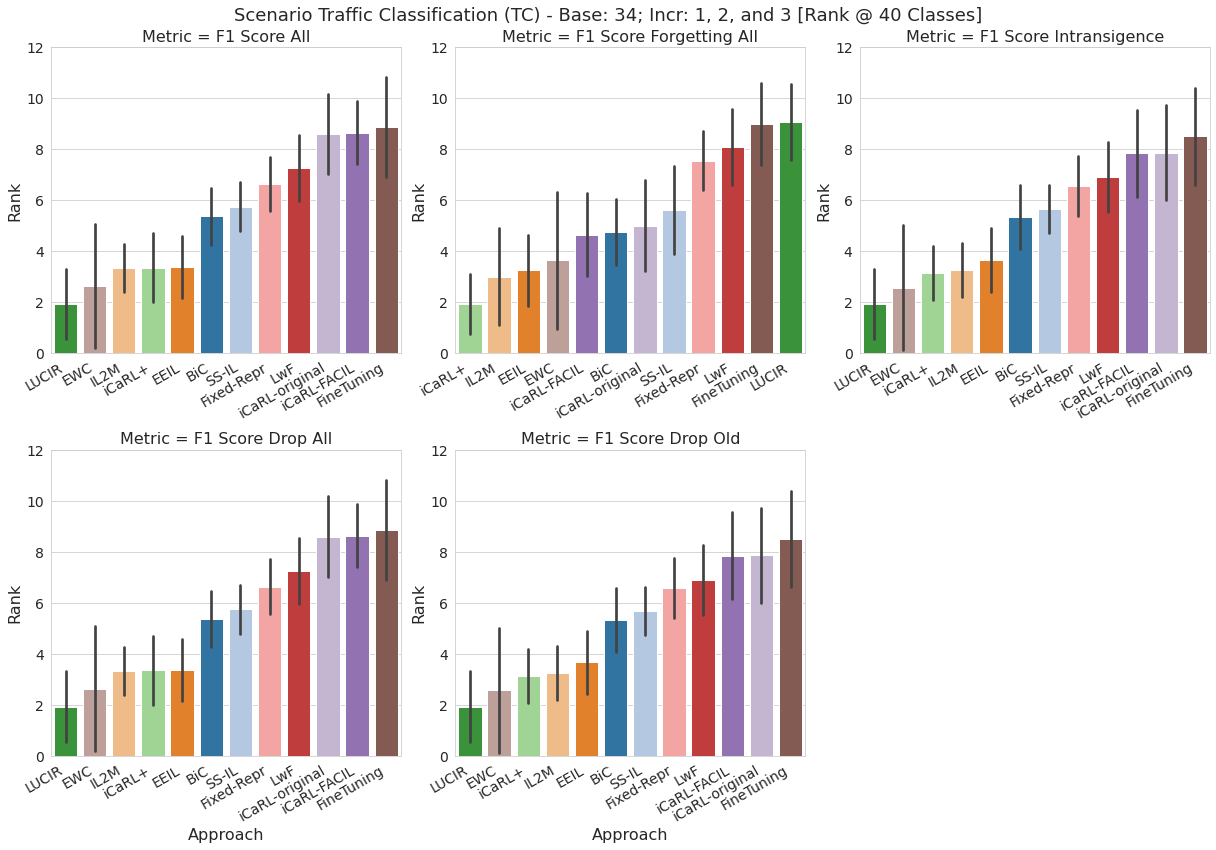

In [8]:
sns.set_style("whitegrid")

nrows = 2
ncols = 3

colors_dict = dict([(k, v) for k, v in zip(
    df_rank['Approach'].unique(), [cm.get_cmap('tab20')(i/20) for i in range(20)])])

for scenario_discrs in scenario_discrs_dict:
    metrics = df_rank[df_rank['Scenario'] == scenario_discrs]['Metric'].unique()
    fig, axes = plt.subplots(nrows, ncols, figsize=(17, 12))
    for i, (ax, metric) in enumerate(zip(np.reshape(axes, np.prod(axes.shape)), metrics)):
        sns.barplot(x='Approach', y='Rank',
                    data=df_rank[(df_rank['Scenario'] == scenario_discrs) & (df_rank['Metric'] == metric)],
                    order=xorder[scenario_discrs][metric], ci='sd',
                    palette=[colors_dict[k] for k in xorder[scenario_discrs][metric]], ax=ax)
        ax.set(ylim=(0, 12))
        ax.set_xticklabels(xorder[scenario_discrs][metric], rotation=30, ha='right')
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_title('Metric = %s' % metric, fontsize=16)
        if i < ncols:
            ax.set_xlabel('')
        else:
            ax.set_xlabel('Approach', fontsize=16)
        ax.set_ylabel('Rank', fontsize=16)
    fig.suptitle('Scenario %s' % scenario_descr_dict[scenario_discrs], fontsize=18)
    fig.delaxes(axes[1][2])
    plt.tight_layout()
    plt.show()


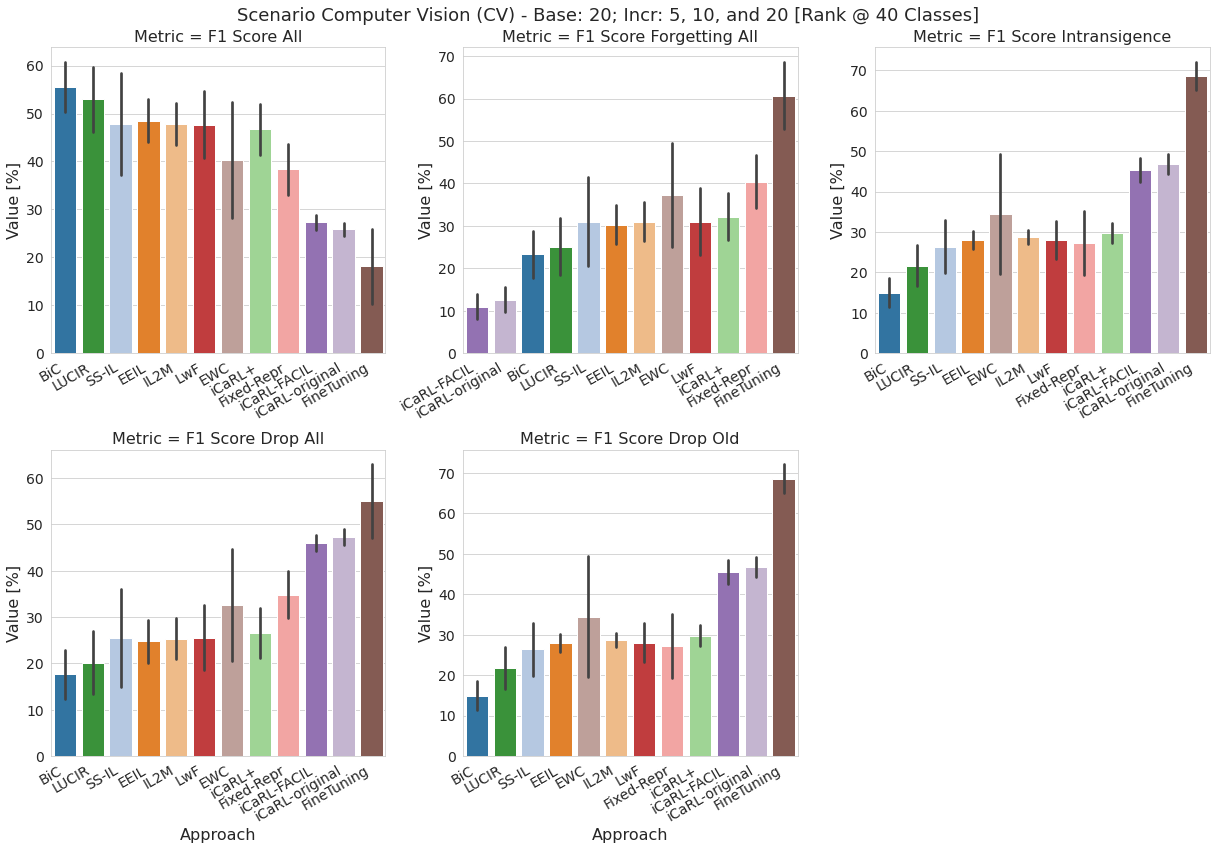

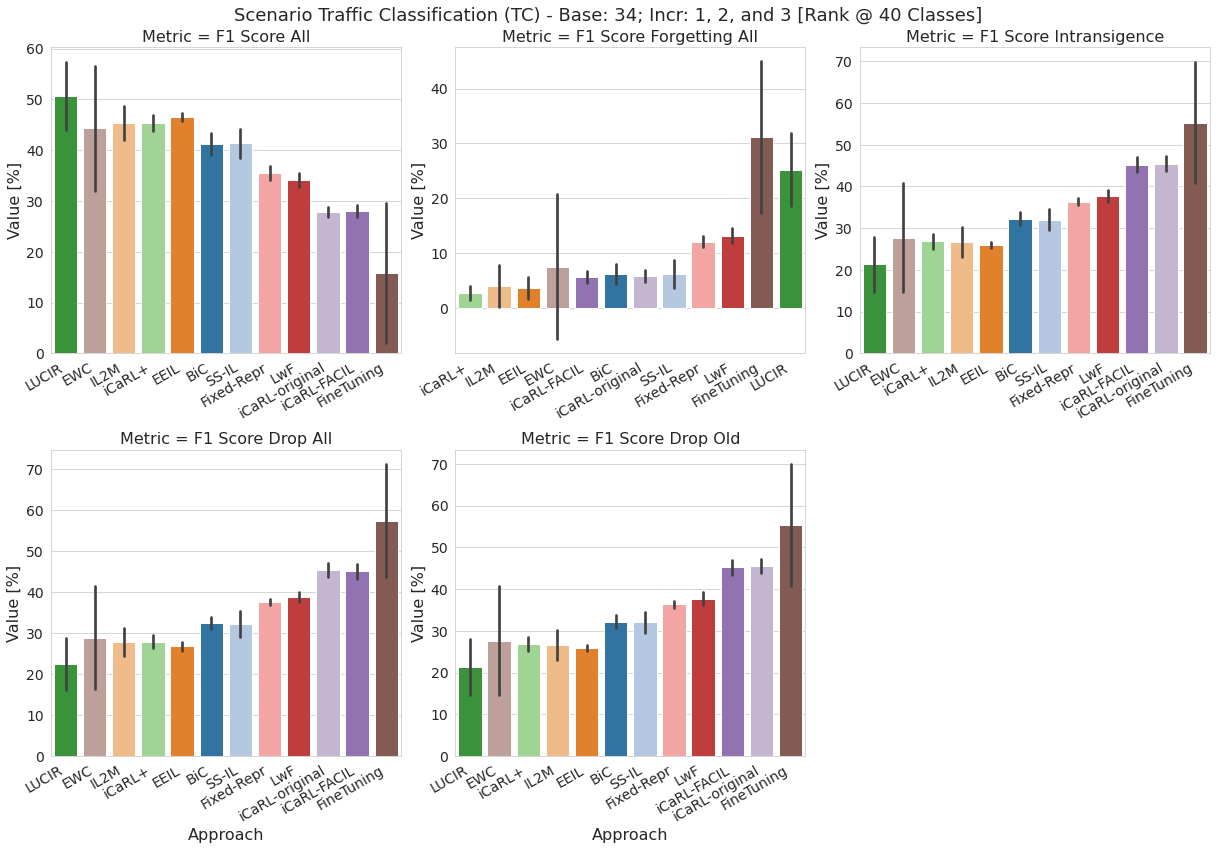

In [9]:
sns.set_style("whitegrid")

nrows = 2
ncols = 3

colors_dict = dict([(k, v) for k, v in zip(
    df_rank['Approach'].unique(), [cm.get_cmap('tab20')(i/20) for i in range(20)])])

for scenario_discrs in scenario_discrs_dict:
    metrics = df_rank[df_rank['Scenario'] == scenario_discrs]['Metric'].unique()
    fig, axes = plt.subplots(nrows, ncols, figsize=(17, 12))
    for i, (ax, metric) in enumerate(zip(np.reshape(axes, np.prod(axes.shape)), metrics)):
        sns.barplot(x='Approach', y='Value [%]',
                    data=df_rank[(df_rank['Scenario'] == scenario_discrs) & (df_rank['Metric'] == metric)],
                    order=xorder[scenario_discrs][metric], ci='sd',
                    palette=[colors_dict[k] for k in xorder[scenario_discrs][metric]], ax=ax)
        ax.set_xticklabels(xorder[scenario_discrs][metric], rotation=30, ha='right')
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_title('Metric = %s' % metric, fontsize=16)
        if i < ncols:
            ax.set_xlabel('')
        else:
            ax.set_xlabel('Approach', fontsize=16)
        ax.set_ylabel('Value [%]', fontsize=16)
    fig.suptitle('Scenario %s' % scenario_descr_dict[scenario_discrs], fontsize=18)
    fig.delaxes(axes[1][2])
    plt.tight_layout()
    plt.show()


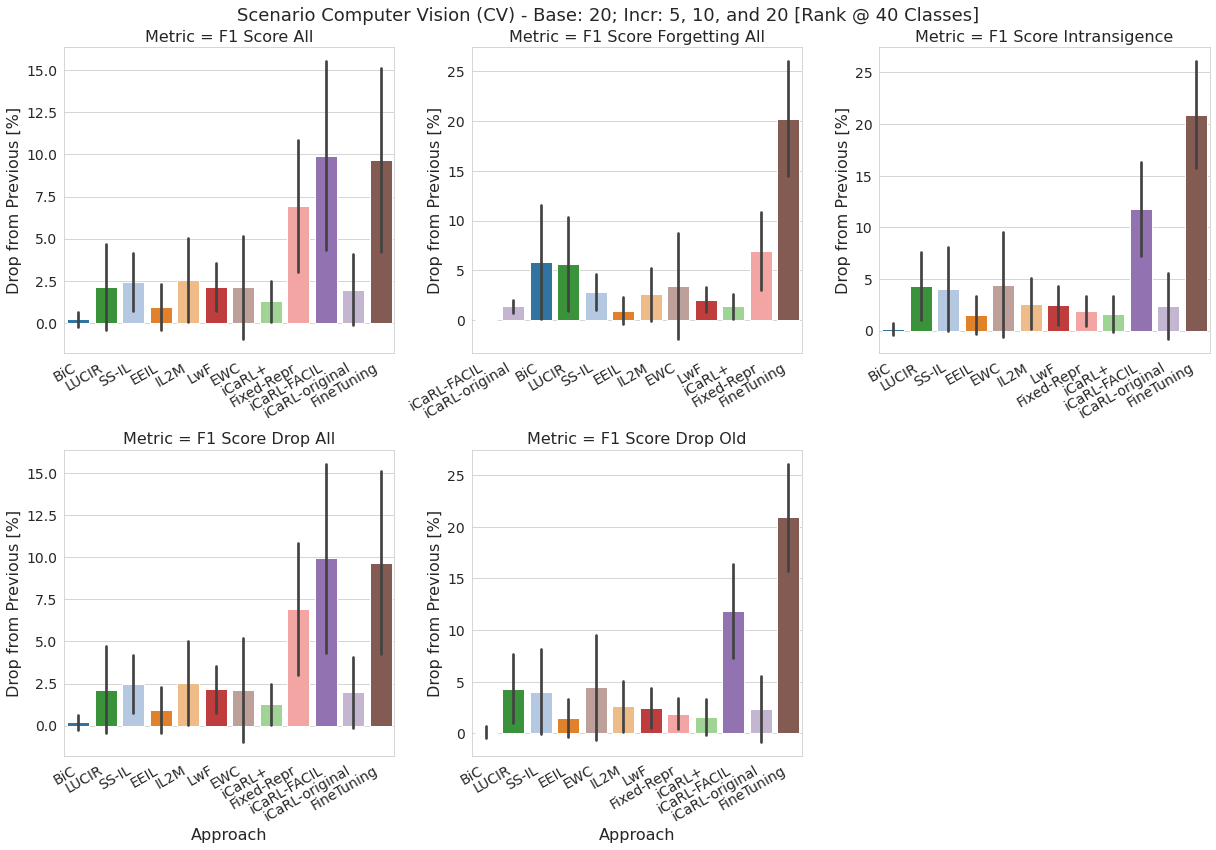

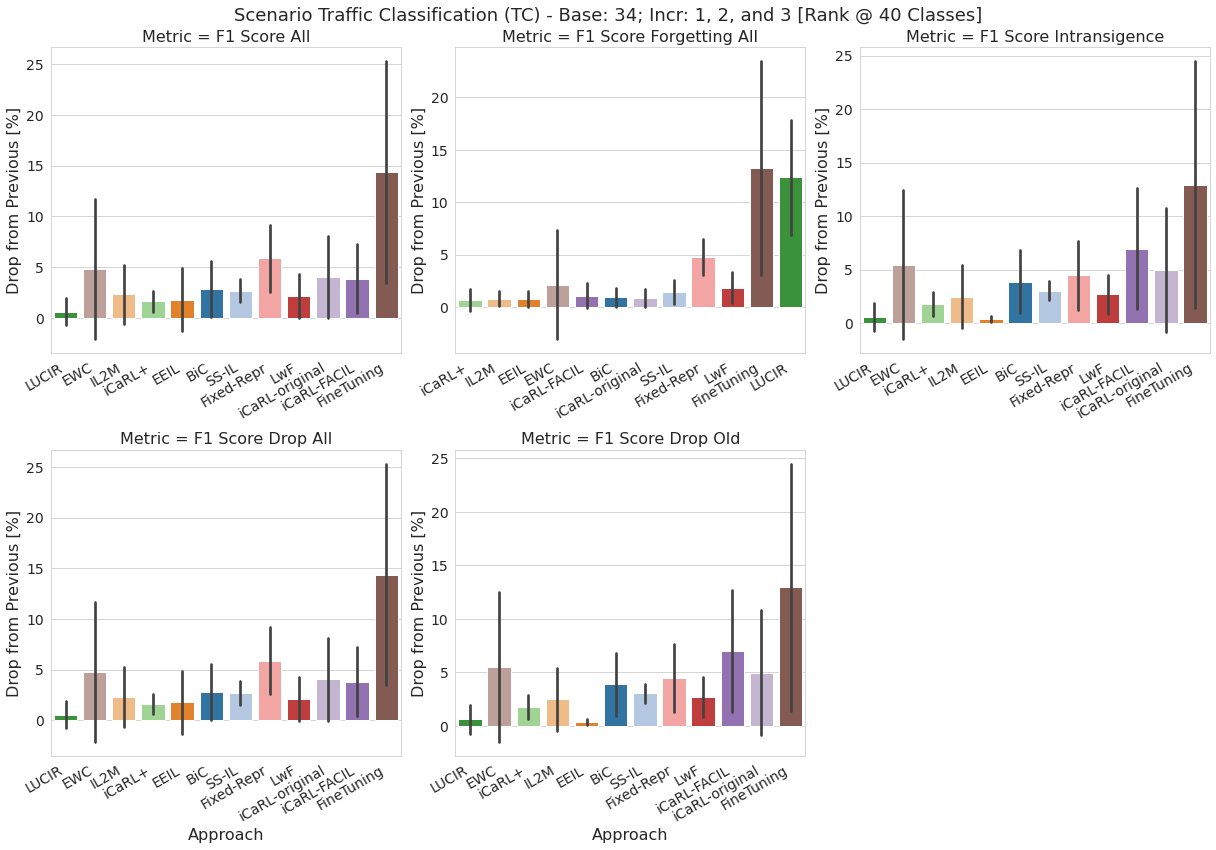

In [10]:
sns.set_style("whitegrid")

nrows = 2
ncols = 3

colors_dict = dict([(k, v) for k, v in zip(
    df_rank['Approach'].unique(), [cm.get_cmap('tab20')(i/20) for i in range(20)])])

for scenario_discrs in scenario_discrs_dict:
    metrics = df_rank[df_rank['Scenario'] == scenario_discrs]['Metric'].unique()
    fig, axes = plt.subplots(nrows, ncols, figsize=(17, 12))
    for i, (ax, metric) in enumerate(zip(np.reshape(axes, np.prod(axes.shape)), metrics)):
        sns.barplot(x='Approach', y='Drop from Previous [%]',
                    data=df_rank[(df_rank['Scenario'] == scenario_discrs) & (df_rank['Metric'] == metric)],
                    order=xorder[scenario_discrs][metric], ci='sd',
                    palette=[colors_dict[k] for k in xorder[scenario_discrs][metric]], ax=ax)
        ax.set_xticklabels(xorder[scenario_discrs][metric], rotation=30, ha='right')
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_title('Metric = %s' % metric, fontsize=16)
        if i < ncols:
            ax.set_xlabel('')
        else:
            ax.set_xlabel('Approach', fontsize=16)
        ax.set_ylabel('Drop from Previous [%]', fontsize=16)
    fig.suptitle('Scenario %s' % scenario_descr_dict[scenario_discrs], fontsize=18)
    fig.delaxes(axes[1][2])
    plt.tight_layout()
    plt.show()


In [51]:
img_path = '/media/nas/datasets/MIRAGE_2020/FSCIL_approaches/hf-project/results/images/'

metric_dict = {
    'Accuracy All': 'all_metrics_accuracy_scoreall-material.parquet',
    'Accuracy Forgetting': 'per_episode_metrics_metrics_forgetting_accuracy_scoreper episode-material.parquet',
    'Accuracy Intransigence': 'new_metrics_accuracy_scorenew intransigence-material.parquet',
    'Accuracy Drop All': 'all_metrics_accuracy_scoredrop all-material.parquet',
    'Accuracy Drop Old': 'old_metrics_accuracy_scoredrop old-material.parquet',
}

lower_is_better_dict = {
    'Accuracy All': False,
    'Accuracy Forgetting': True,
    'Accuracy Intransigence': True,
    'Accuracy Drop All': True,
    'Accuracy Drop Old': True,
}

scenario_discrs_dict = {
    'CV': ['can5ba20inr5stp5', 'can5ba20in10stp3', 'can5ba20in20stp2'],
    'TC': ['can5ba34inr1stp7', 'can5ba34inr2stp4', 'can5ba34inr3stp3']
}

scenario_descr_dict = {
    'CV': 'Computer Vision (CV) - Base: 20; Incr: 5, 10, and 20 [Rank @ 40 Classes]',
    'TC': 'Traffic Classification (TC) - Base: 34; Incr: 1, 2, and 3 [Rank @ 40 Classes]'
}

In [53]:
df_rank = pd.DataFrame(columns=['Approach', 'Group', 'Metric', 'Rank'])
fixed_xorder = dict()
xorder = dict()
for scenario_discrs in tqdm(scenario_discrs_dict):
    fixed_xorder[scenario_discrs] = None
    xorder[scenario_discrs] = dict()
    for metric in metric_dict:
        xorder[scenario_discrs][metric] = None
        files = []
        for scenario_discr in scenario_discrs_dict[scenario_discrs]:
            files.extend(glob('%s/%s_*/material/%s' % (img_path, scenario_discr, metric_dict[metric])))
        df = pd.DataFrame()
        for file in files:
            df = df.append(pd.read_parquet(file), ignore_index=True)

        df = df[df['Approach'] != 'Scratch']

        df_40 = df[df['#Classes'] == 40]

        for g, d in df_40.groupby(['Seed', 'Increment']):
            tmp_d = d.drop_duplicates('Approach')
            tmp_df_rank = pd.DataFrame()
            row = {'Scenario': scenario_discrs, 'Group': g, 'Metric': metric}
            # if len(d) != 12:
            #     continue
            for r, appr in enumerate(
                    tmp_d.sort_values(metric, ascending=lower_is_better_dict[metric])['Approach'].values):
                row.update({'Approach': appr, 'Rank': r + 1,
                            'Value [%]': tmp_d[tmp_d['Approach'] == appr][metric].values[0]})
                tmp_df_rank = tmp_df_rank.append(row, ignore_index=True)
            prev_val = tmp_df_rank.loc[0, 'Value [%]']
            for i in range(len(tmp_df_rank)):
                curr_val = tmp_df_rank.loc[i, 'Value [%]']
                tmp_df_rank.loc[i, 'Drop from Previous [%]'] = (prev_val - curr_val) * (
                    -1 if lower_is_better_dict[metric] else 1)
                prev_val = curr_val
            df_rank = df_rank.append(tmp_df_rank, ignore_index=True)

        if fixed_xorder[scenario_discrs] is None:
            fixed_xorder[scenario_discrs] = list(
                df_rank[df_rank['Scenario'] == scenario_discrs].groupby('Approach')['Rank'].mean().sort_values().index)
        
        if xorder[scenario_discrs][metric] is None:
            xorder[scenario_discrs][metric] = list(
                df_rank[(df_rank['Scenario'] == scenario_discrs) & (df_rank['Metric'] == metric)].groupby(
                    'Approach')['Rank'].mean().sort_values().index)


  0%|                                                                                                            | 0/2 [00:00<?, ?it/s]


[]


KeyError: 'Approach'

In [36]:
df

,Seed,Network,Approach,Episode,Batch Size,Patience,Increment,Task,Accuracy Per Episode,#Classes,Momentum,Out Features Size,Accuracy Per Episode Intransigence
0,4,Lopez17CNN,LUCIR,0,64,20,1,0,80.056537,34.0,0.0,200.0,1.191991
1,4,Lopez17CNN,LUCIR,1,64,20,1,0,56.994111,35.0,0.0,200.0,22.709069
2,4,Lopez17CNN,LUCIR,1,64,20,1,1,80.504587,35.0,0.0,200.0,-22.935780
3,4,Lopez17CNN,LUCIR,2,64,20,1,0,43.924617,36.0,0.0,200.0,33.795053
4,4,Lopez17CNN,LUCIR,2,64,20,1,1,15.825688,36.0,0.0,200.0,39.678899
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2170,3,Lopez17CNN,LwF,1,64,20,3,0,51.262638,37.0,0.0,200.0,25.465839
2171,3,Lopez17CNN,LwF,1,64,20,3,1,1.612903,37.0,0.0,200.0,77.449223
2172,3,Lopez17CNN,LwF,2,64,20,3,0,50.206284,40.0,0.0,200.0,25.284490
2173,3,Lopez17CNN,LwF,2,64,20,3,1,1.373955,40.0,0.0,200.0,77.508961


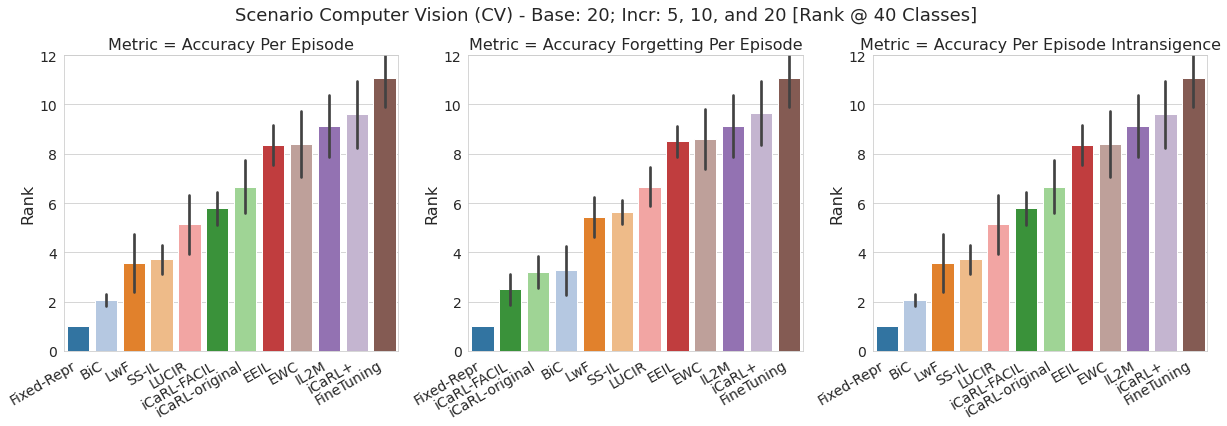

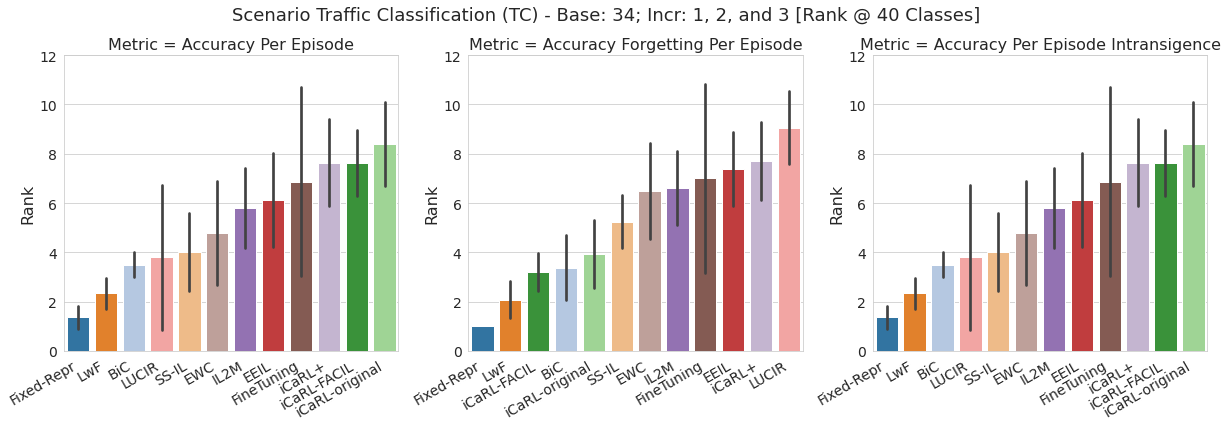

In [34]:
sns.set_style("whitegrid")

nrows = 1
ncols = 3

colors_dict = dict([(k, v) for k, v in zip(
    df_rank['Approach'].unique(), [cm.get_cmap('tab20')(i/20) for i in range(20)])])

for scenario_discrs in scenario_discrs_dict:
    metrics = df_rank[df_rank['Scenario'] == scenario_discrs]['Metric'].unique()
    fig, axes = plt.subplots(nrows, ncols, figsize=(17, 6))
    for i, (ax, metric) in enumerate(zip(np.reshape(axes, np.prod(axes.shape)), metrics)):
        sns.barplot(x='Approach', y='Rank',
                    data=df_rank[(df_rank['Scenario'] == scenario_discrs) & (df_rank['Metric'] == metric)],
                    order=xorder[scenario_discrs][metric], ci='sd',
                    palette=[colors_dict[k] for k in xorder[scenario_discrs][metric]], ax=ax)
        ax.set(ylim=(0, 12))
        ax.set_xticklabels(xorder[scenario_discrs][metric], rotation=30, ha='right')
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_title('Metric = %s' % metric, fontsize=16)
        if i < ncols:
            ax.set_xlabel('')
        else:
            ax.set_xlabel('Approach', fontsize=16)
        ax.set_ylabel('Rank', fontsize=16)
    fig.suptitle('Scenario %s' % scenario_descr_dict[scenario_discrs], fontsize=18)
    plt.tight_layout()
    plt.show()
